# LDA para o Documento Curricular Referencial do Ceará para Educação Infantil (EI) e Ensino Fundamental (EF) / Com exclusão das top 30 palavras + palavras dos tópicos da BNCC:

## Importação das bibliotecas:

In [1]:
# Para ler o PDF:
import PyPDF2

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

## 1. Importação do corpus (stem) e retirada das top 30 palavras + palavras dos tópicos da BNCC:

In [4]:
# Abrir o arquivo no modo de leitura binária
with open("CE_stem.pkl", 'rb') as file:
    # Carregar o conteúdo do arquivo pickled
    df = pickle.load(file)

In [5]:
df

,frases,Preprocessado,Sem_stopwords,Stem
0,"['INTRODUÇÃO ', ' ', ' ', ' ', 'O ', 'Document...","[introducao, documento, curricular, referencia...","[introducao, documento, curricular, referencia...","[introduca, document, curricul, refer, ce, dor..."
1,Contamos com todos para torná-lo realidade ...,"[contamos, com, todos, para, torna, realidade,...","[contamos, torna, realidade, sala, aula, insti...","[cont, torn, real, sal, aul, instituico, educa..."
2,"', 'Mais do que um referencial norteador ...","[mais, que, referencial, norteador, dos, compr...","[referencial, norteador, compromissos, assumid...","[refer, norte, compromiss, assum, ges, publ, m..."
3,"', 'Cumpre salientar que o documento em pauta ...","[cumpre, salientar, que, documento, pauta, foi...","[cumpre, salientar, documento, pauta, construi...","[cumpr, salient, document, paut, constru, luz,..."
4,"Buscamos, assim, promover o conhecimento d...","[buscamos, assim, promover, conhecimento, aspe...","[buscamos, promover, conhecimento, aspectos, i...","[busc, promov, conhec, aspect, import, cult, h..."
...,...,...,...,...
4770,"[' ', '||Crenças religiosas e filosofias de vi...","[crencas, religiosas, filosofias, vida, import...","[crencas, religiosas, filosofias, vida, import...","[crenc, religi, filosof, vid, importanc, escol..."
4771,"[' ', ' ', '588', '||Crenças religiosas e filo...","[crencas, religiosas, filosofias, vida, analis...","[crencas, religiosas, filosofias, vida, analis...","[crenc, religi, filosof, vid, analis, projet, ..."
4772,- Compreender a aplicabilidade da laicidade no...,"[compreender, aplicabilidade, laicidade, nosso...","[compreender, aplicabilidade, laicidade, conte...","[compreend, aplic, laic, context, sociocult, a..."
4773,"[' ', '||Crenças religiosas e filosofias de vi...","[crencas, religiosas, filosofias, vida, identi...","[crencas, religiosas, filosofias, vida, identi...","[crenc, religi, filosof, vid, identific, difer..."


In [6]:
def excluir_strings_especificas(dataframe, coluna, strings_para_excluir):
    """
    Remove as strings específicas da coluna 'coluna' do dataframe 'dataframe'.
    
    Parâmetros:
    - dataframe: O dataframe pandas.
    - coluna: Nome da coluna que contém as listas de strings.
    - strings_para_excluir: Lista de strings que devem ser removidas de cada lista na coluna.
    
    Retorna:
    Um novo dataframe com as strings removidas.
    """
    # Função para aplicar em cada linha da coluna
    def remover_strings(lista_original):
        nova_lista = [item.strip() for item in lista_original if item.strip() not in strings_para_excluir]
        return nova_lista

    # Aplicar a função em cada linha da coluna
    dataframe[coluna] = dataframe[coluna].apply(remover_strings)

    return dataframe

In [7]:
strings_BNCC = ['difer',
                'text',
                'lingu',
                'conhec',
                'pra',
                'cult',
                'ano',
                'analis',
                'soc',
                'ensin',
                'habil',
                'identific',
                'produca',
                'objet',
                'desenvolv',
                'camp',
                'estud',
                'etc',
                'divers',
                'natur',
                'uso',
                'vid',
                'context',
                'leit',
                'fundament',
                'brasil',
                'process',
                'educaca',
                'espac',
                'utiliz',
                'religi',
                'mund',
                'are',
                'nacion',
                'lei',
                'basic',
                'disponi',
                'tecnolog',
                'problem',
                'envolv',
                'digit']

In [8]:
df = excluir_strings_especificas(df, 'Stem', strings_BNCC)

In [9]:
df

,frases,Preprocessado,Sem_stopwords,Stem
0,"['INTRODUÇÃO ', ' ', ' ', ' ', 'O ', 'Document...","[introducao, documento, curricular, referencia...","[introducao, documento, curricular, referencia...","[introduca, document, curricul, refer, ce, dor..."
1,Contamos com todos para torná-lo realidade ...,"[contamos, com, todos, para, torna, realidade,...","[contamos, torna, realidade, sala, aula, insti...","[cont, torn, real, sal, aul, instituico, educa..."
2,"', 'Mais do que um referencial norteador ...","[mais, que, referencial, norteador, dos, compr...","[referencial, norteador, compromissos, assumid...","[refer, norte, compromiss, assum, ges, publ, m..."
3,"', 'Cumpre salientar que o documento em pauta ...","[cumpre, salientar, que, documento, pauta, foi...","[cumpre, salientar, documento, pauta, construi...","[cumpr, salient, document, paut, constru, luz,..."
4,"Buscamos, assim, promover o conhecimento d...","[buscamos, assim, promover, conhecimento, aspe...","[buscamos, promover, conhecimento, aspectos, i...","[busc, promov, aspect, import, hist, valoriz, ..."
...,...,...,...,...
4770,"[' ', '||Crenças religiosas e filosofias de vi...","[crencas, religiosas, filosofias, vida, import...","[crencas, religiosas, filosofias, vida, import...","[crenc, filosof, importanc, escolh, respeit, e..."
4771,"[' ', ' ', '588', '||Crenças religiosas e filo...","[crencas, religiosas, filosofias, vida, analis...","[crencas, religiosas, filosofias, vida, analis...","[crenc, filosof, projet, aco, fortalec, laic, ..."
4772,- Compreender a aplicabilidade da laicidade no...,"[compreender, aplicabilidade, laicidade, nosso...","[compreender, aplicabilidade, laicidade, conte...","[compreend, aplic, laic, sociocult, projet, po..."
4773,"[' ', '||Crenças religiosas e filosofias de vi...","[crencas, religiosas, filosofias, vida, identi...","[crencas, religiosas, filosofias, vida, identi...","[crenc, filosof, form, compreend, conceit, imo..."


## 2. LDA:

In [10]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [11]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [12]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [13]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [11:30<00:00, 32.89s/it]


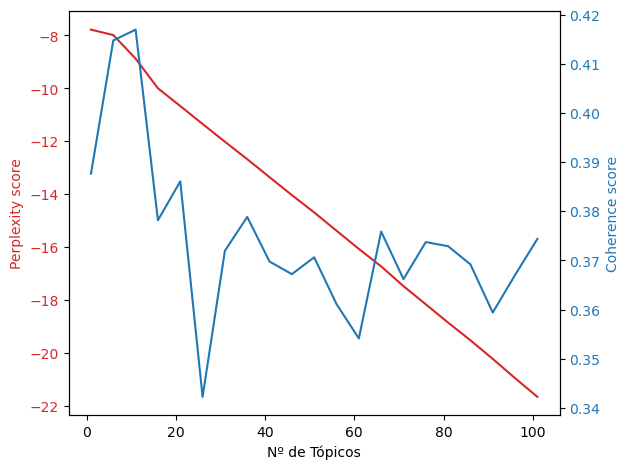

In [14]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('CE_2_Coherence Score_100 topicos.png')

plt.show()

In [15]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.3876  e valor de perplexidade de -7.7828
A quantidade de tópicos = 6  tem um valor de coerência de  0.4148  e valor de perplexidade de -7.9882
A quantidade de tópicos = 11  tem um valor de coerência de  0.417  e valor de perplexidade de -8.8776
A quantidade de tópicos = 16  tem um valor de coerência de  0.3782  e valor de perplexidade de -9.9992
A quantidade de tópicos = 21  tem um valor de coerência de  0.3861  e valor de perplexidade de -10.668
A quantidade de tópicos = 26  tem um valor de coerência de  0.3422  e valor de perplexidade de -11.3454
A quantidade de tópicos = 31  tem um valor de coerência de  0.372  e valor de perplexidade de -12.0162
A quantidade de tópicos = 36  tem um valor de coerência de  0.3789  e valor de perplexidade de -12.6756
A quantidade de tópicos = 41  tem um valor de coerência de  0.3698  e valor de perplexidade de -13.3557
A quantidade de tópicos = 46  tem um valor de coerência de  0.3672  e val

In [16]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=21,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:21<00:00, 31.07s/it]


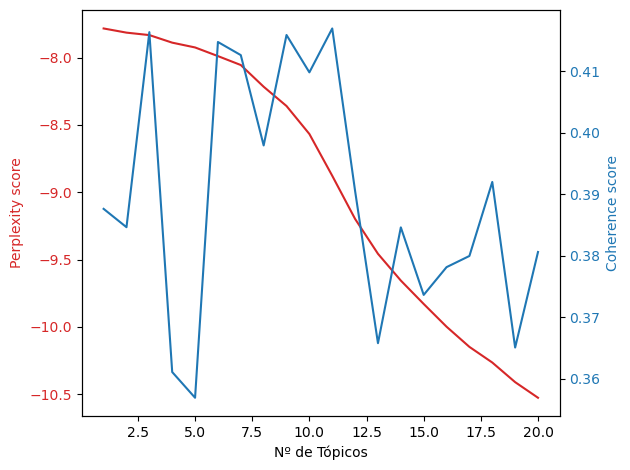

In [17]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=21; start=1; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('CE_2_Coherence Score_21 topicos.png')

plt.show()

In [18]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.3876  e valor de perplexidade de -7.7828
A quantidade de tópicos = 2  tem um valor de coerência de  0.3847  e valor de perplexidade de -7.8138
A quantidade de tópicos = 3  tem um valor de coerência de  0.4164  e valor de perplexidade de -7.8321
A quantidade de tópicos = 4  tem um valor de coerência de  0.3611  e valor de perplexidade de -7.8883
A quantidade de tópicos = 5  tem um valor de coerência de  0.3569  e valor de perplexidade de -7.9239
A quantidade de tópicos = 6  tem um valor de coerência de  0.4148  e valor de perplexidade de -7.9882
A quantidade de tópicos = 7  tem um valor de coerência de  0.4126  e valor de perplexidade de -8.0546
A quantidade de tópicos = 8  tem um valor de coerência de  0.398  e valor de perplexidade de -8.2159
A quantidade de tópicos = 9  tem um valor de coerência de  0.4159  e valor de perplexidade de -8.3592
A quantidade de tópicos = 10  tem um valor de coerência de  0.4098  e valor de perp

In [44]:
# Valor escolhido para coherence score foi 14 tópicos (coherence score = 0.417):
# Número de tópicos
num_topicos = 11

In [45]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [46]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('poli', 0.018533127), ('crenc', 0.016989006), ('guerr', 0.014598034), ('map', 0.012921697), ('critic', 0.009677428), ('etic', 0.009500273), ('trabalh', 0.008106683), ('relaca', 0.007755666), ('curricul', 0.007609644), ('escol', 0.0073646707)]
Topic 1: [('interpretaco', 0.017883245), ('relaca', 0.016536023), ('diferen', 0.01560586), ('posici', 0.013636792), ('afric', 0.01287658), ('viso', 0.012209959), ('pais', 0.011088169), ('ingl', 0.009912301), ('form', 0.007493072), ('sociedad', 0.007485425)]
Topic 2: [('pov', 0.024966715), ('histor', 0.023374803), ('indigen', 0.013797651), ('lut', 0.011875308), ('ce', 0.011841817), ('terr', 0.01183512), ('logic', 0.010898726), ('long', 0.010190569), ('sociedad', 0.010144353), ('econom', 0.0100512495)]
Topic 3: [('solidari', 0.017814243), ('independenc', 0.015705654), ('critic', 0.015231277), ('pais', 0.014713721), ('te', 0.013699213), ('memor', 0.013406479), ('econom', 0.011343812), ('ocean', 0.011237038), ('sustenta', 0.010746543), ('ti

### Visualizações:

In [47]:
# Visualização dos tópicos:
visualizacao_BNCC = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [48]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_BNCC, r"CE_2_visualizacao_BNCC_11_topicos.html")

### Distribuição de palavras por frase:

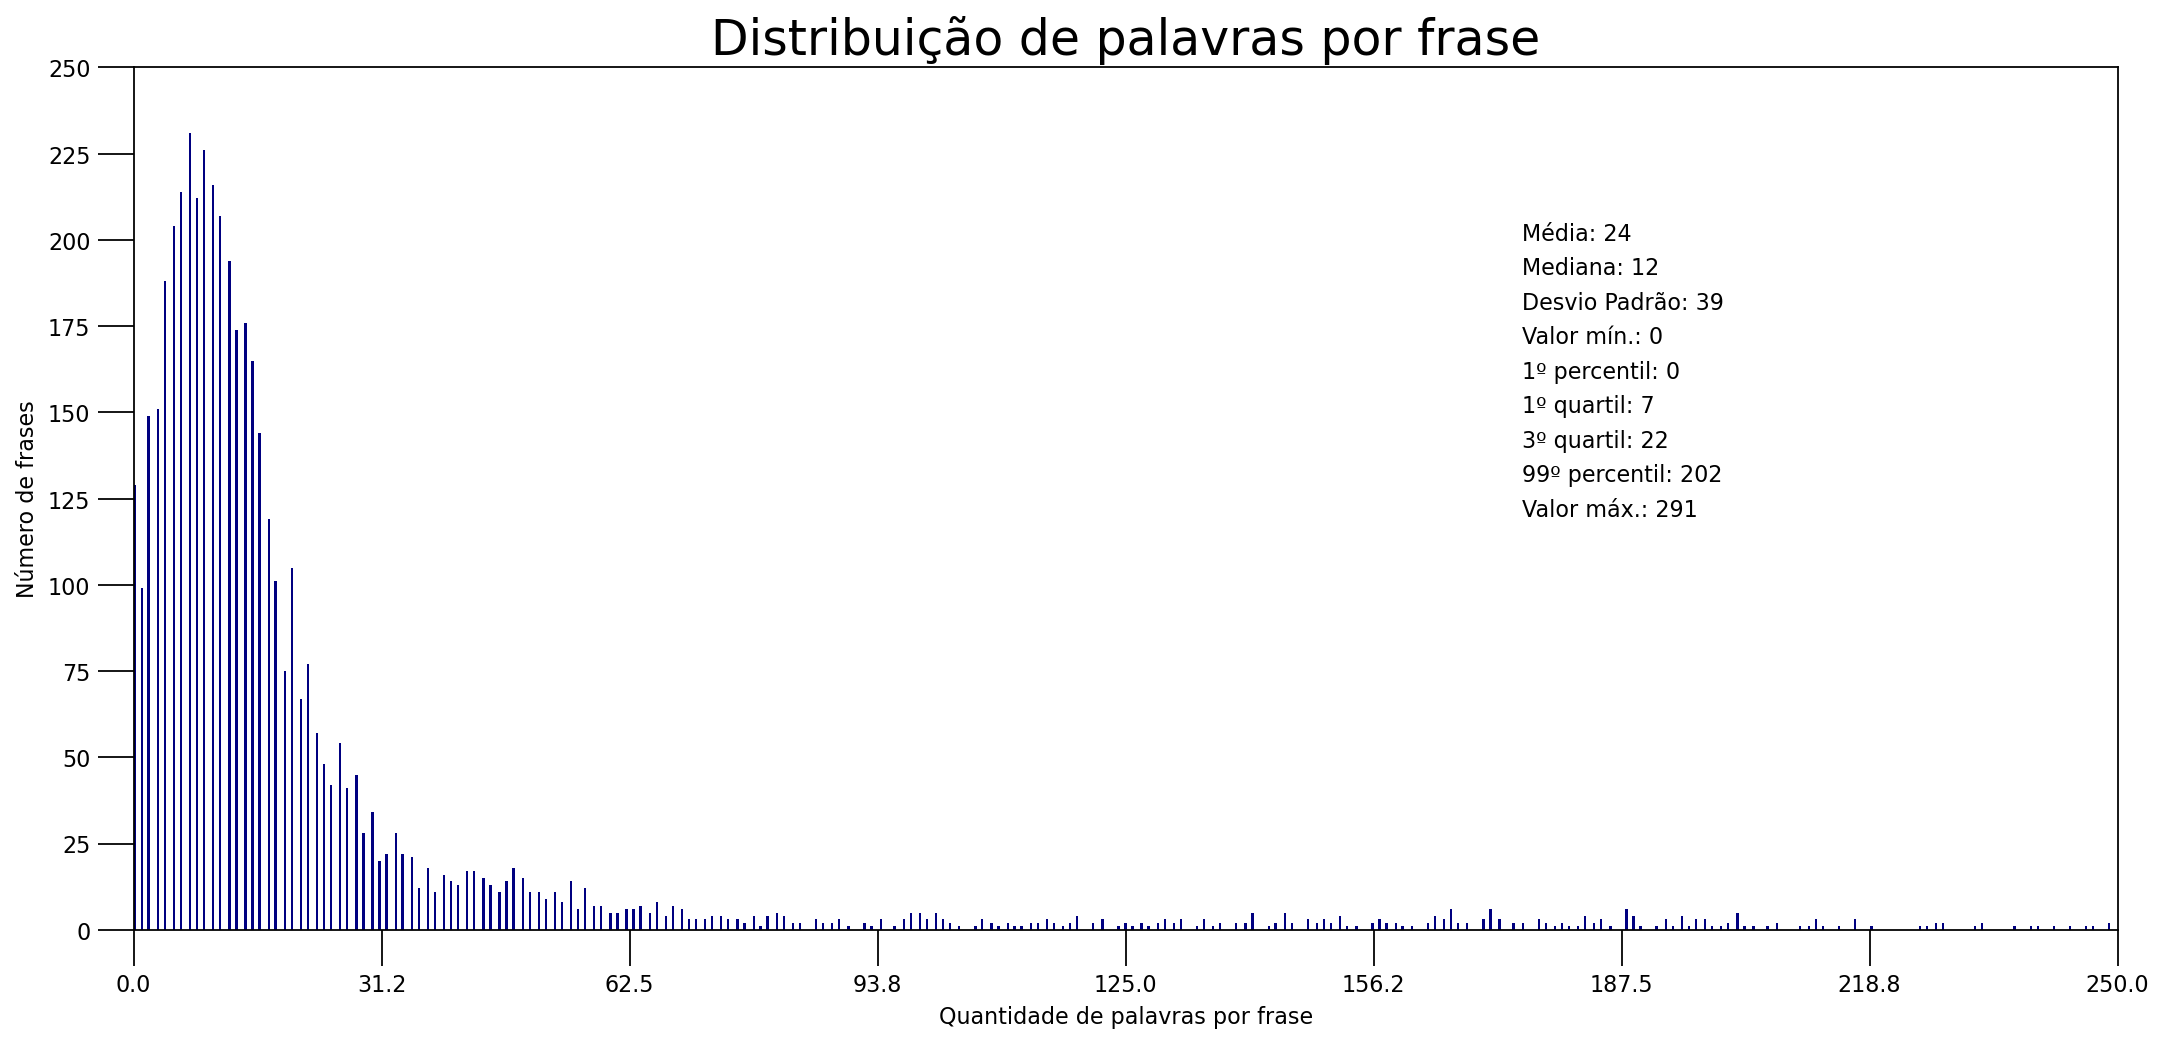

In [52]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(175, 200, "Média: " + str(round(np.mean(doc_lens))))
plt.text(175, 190, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(175, 180, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(175, 170, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(175, 160, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(175, 150, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(175, 140, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(175, 130, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(175, 120, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 250), ylim=(0, 250), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.yticks(np.linspace(0,250,11))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('CE_2_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [53]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

,Palavra,Frequência
0,crianc,925
1,escol,798
2,reconhec,690
3,escrit,629
4,numer,557
5,form,522
6,sent,517
7,atuaca,466
8,relaca,448
9,nao,444


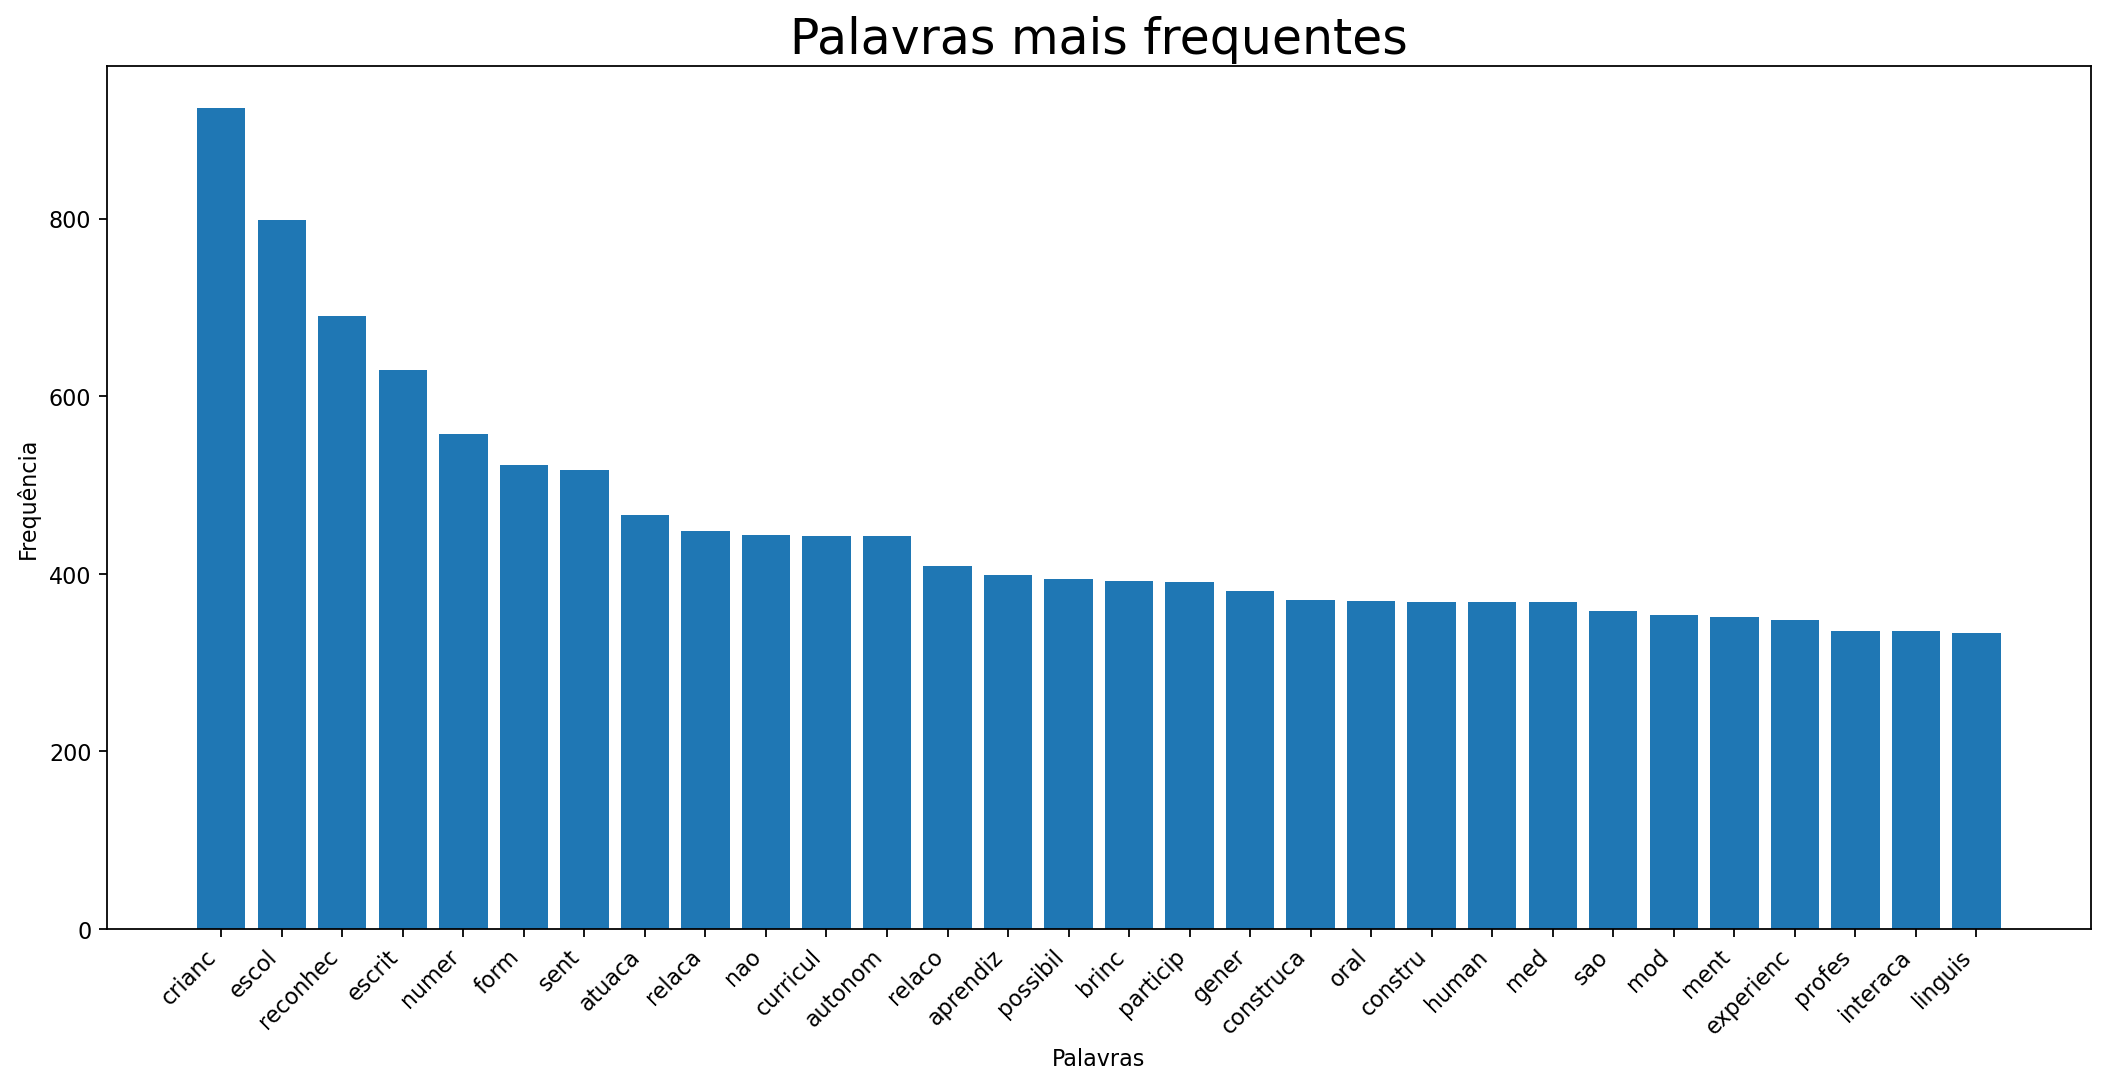

In [54]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('CE_2_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

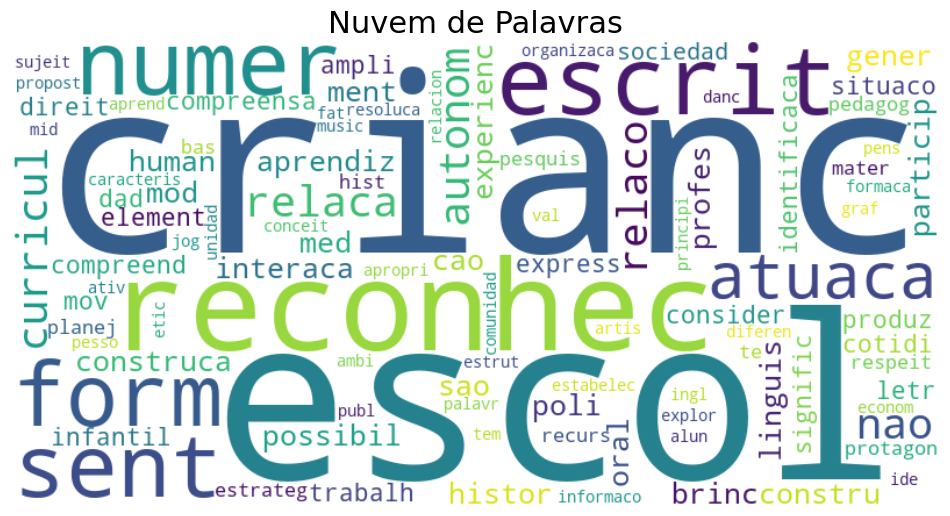

In [55]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('CE_2_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [57]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(num_topics=num_topicos, formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_23452\1615616278.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23452\1615616278.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23452\1615616278.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23452\1615616278.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

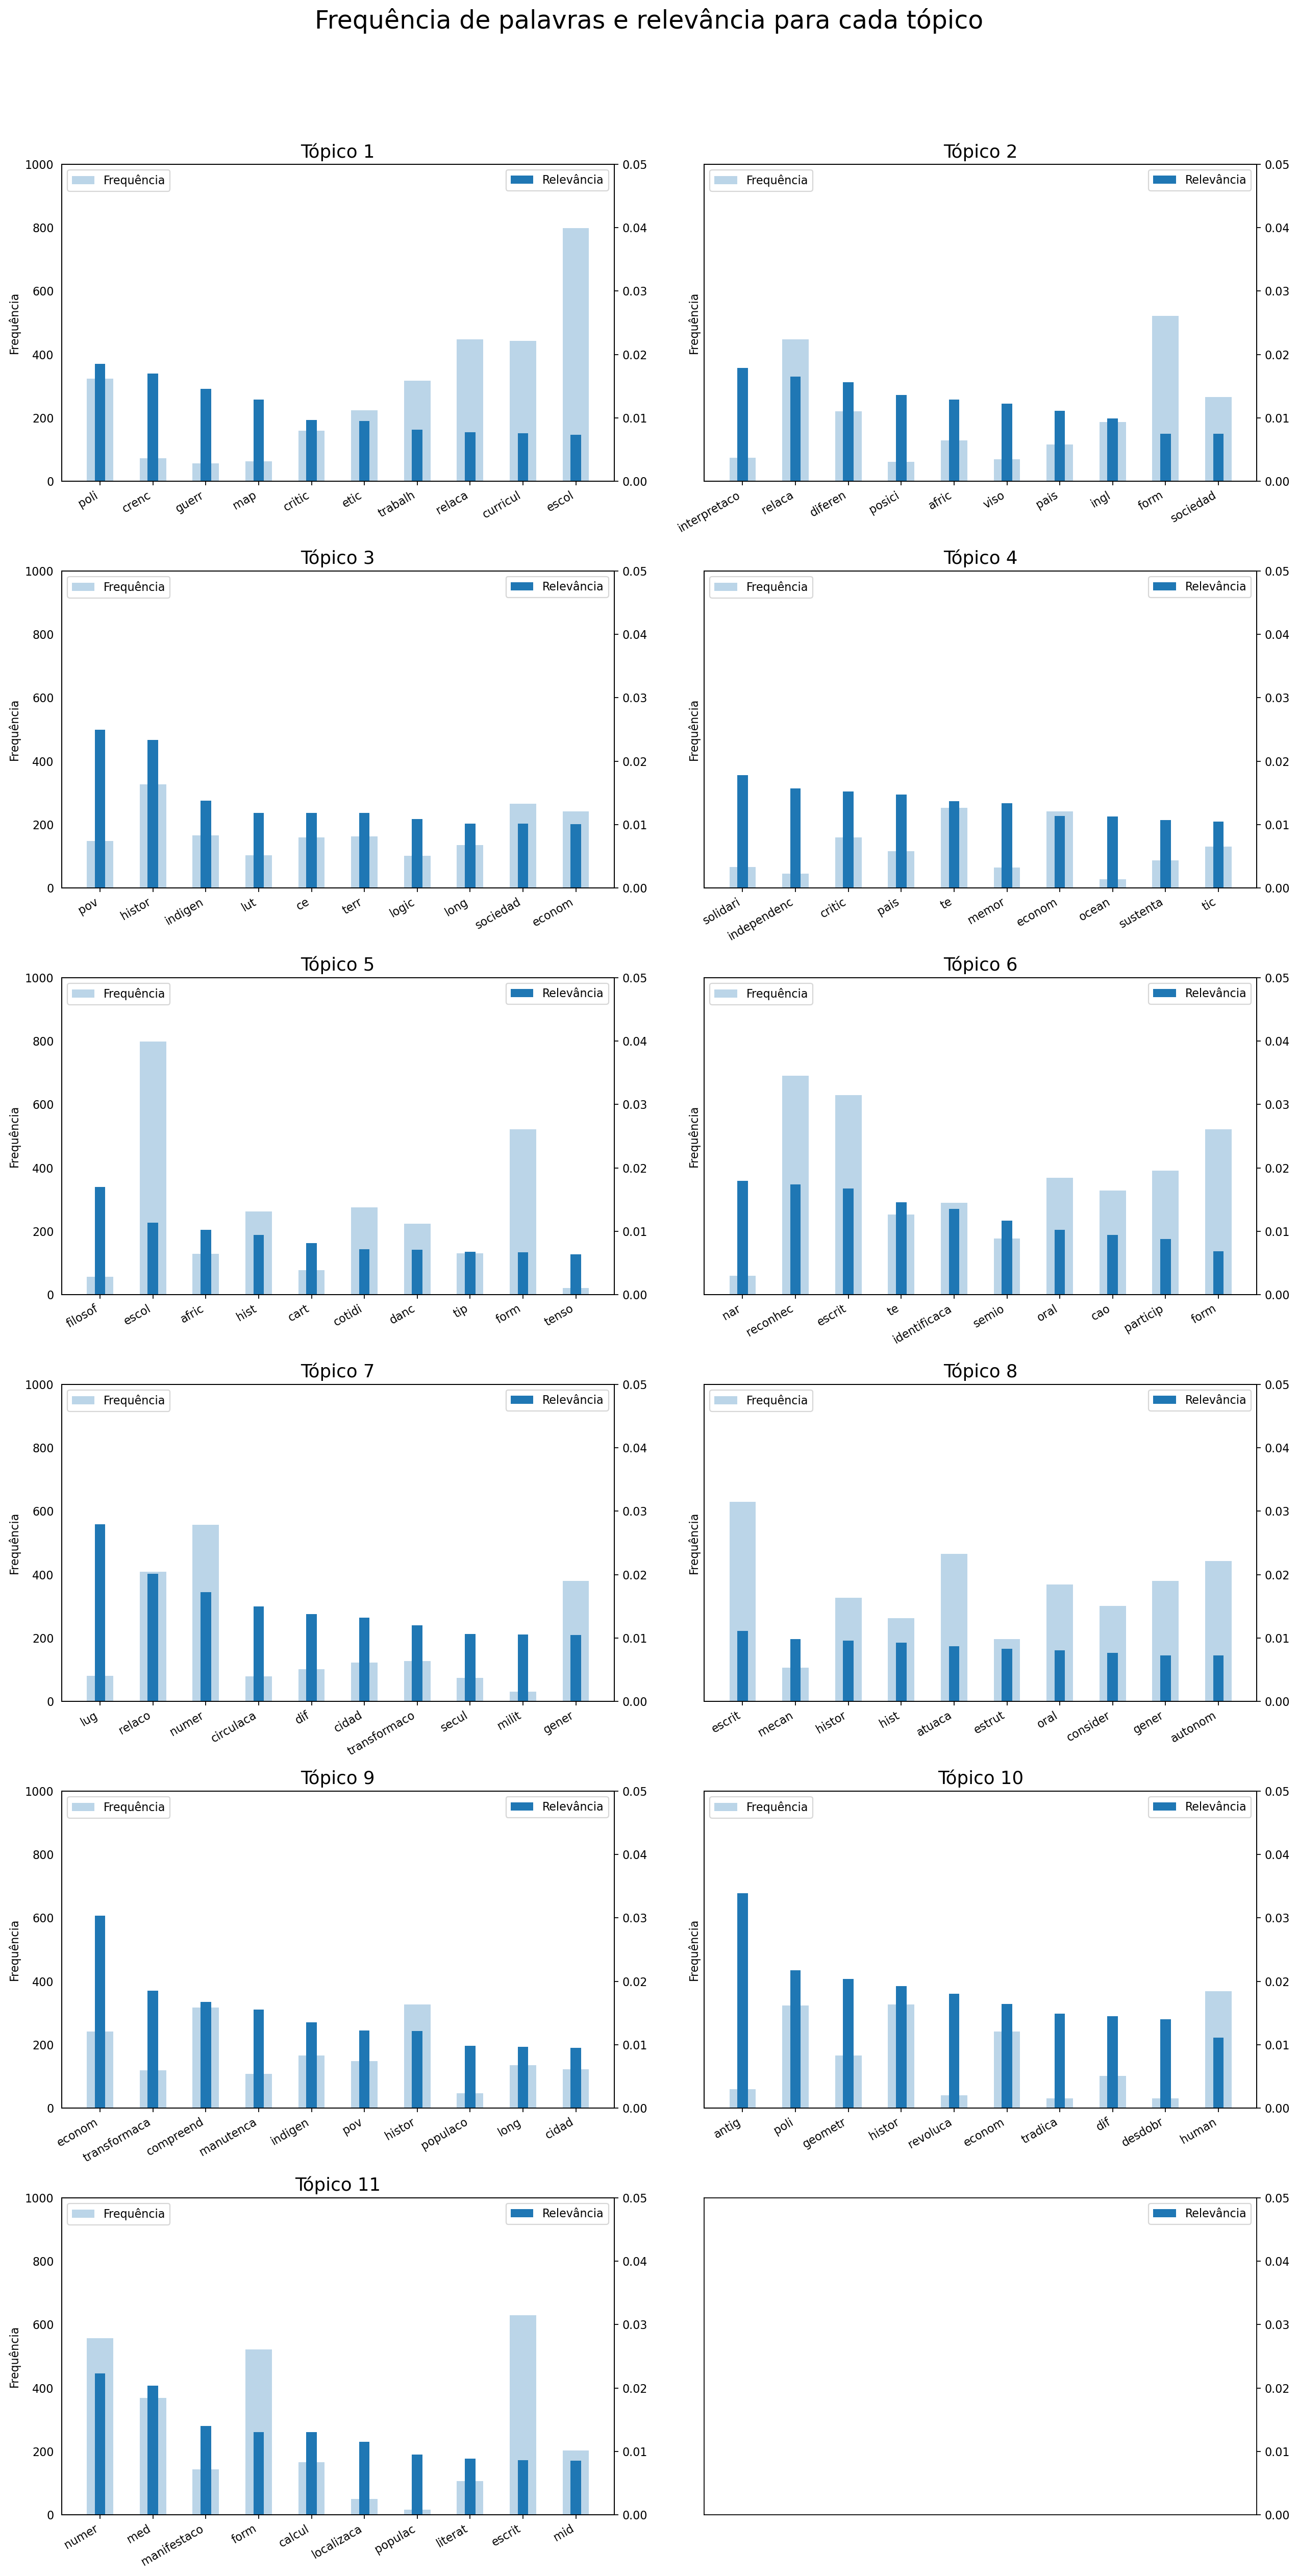

In [71]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(6, 2, figsize=(16,30), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 1000)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 12º subplot (na 6ª linha e 2ª coluna):
fig.delaxes(axes[5, 1])    

fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('CE_2_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

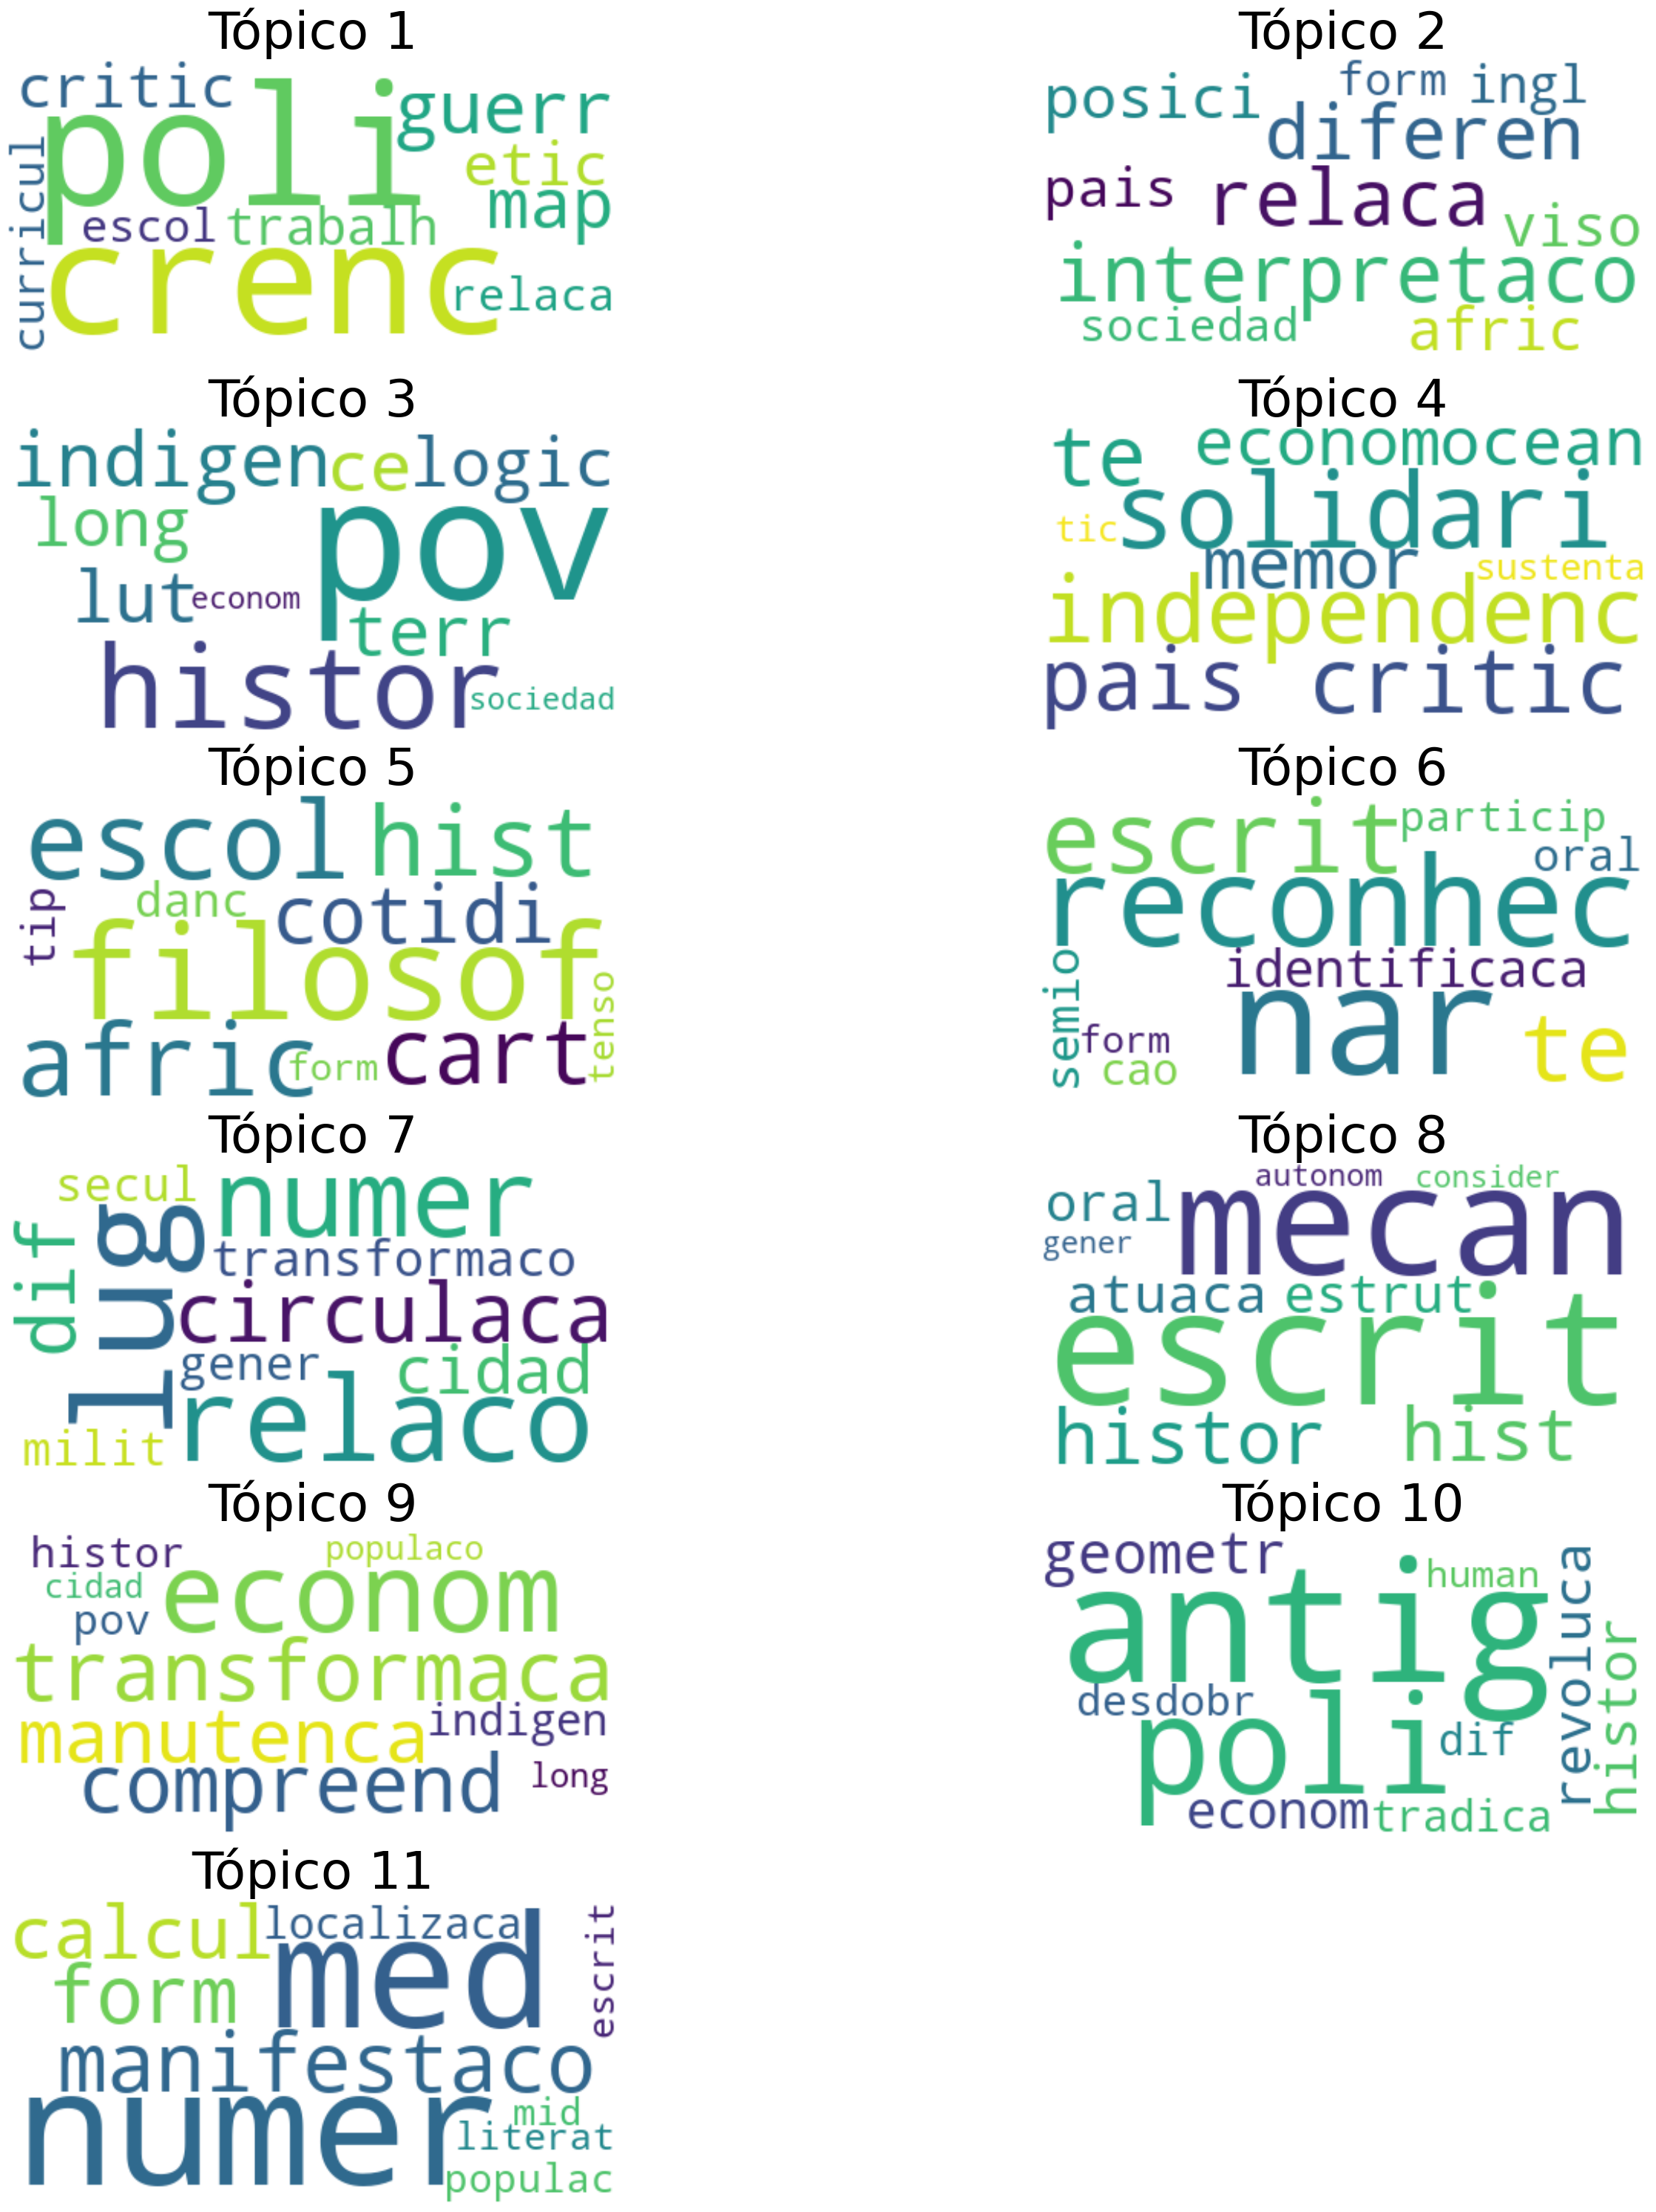

In [70]:
# Configuração do layout dos subplots
num_linhas = 6
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(30, 30)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=50))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('CE_2_Nuvem de palavras por topico.png')

plt.show()